In [ ]:
%%capture
!pip install -U transformers
!pip install sentencepiece
!pip install datasets

from transformers import AutoTokenizer, TFBertModel, TFAutoModel, BertTokenizer, BertConfig
import pickle
from tqdm import tqdm
from sklearn.metrics import classification_report, recall_score, f1_score
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import *
import tensorflow as tf
import pandas as pd
import numpy as np
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual')
label2id = {

    '-1' : 0,
    '0' : 1,
    '1' : 2,
    '2' : 2,
    '3' : 2
}
id2label = {v: k for k, v in label2id.items()}



def get_pre_model():
    xLMR = TFAutoModel.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual', from_pt = True)


    return xLMR

In [ ]:
!gdown 1i-WmVzLYvhxg0fh6lzId37JOOLSLOR4W

Downloading...
From: https://drive.google.com/uc?id=1i-WmVzLYvhxg0fh6lzId37JOOLSLOR4W
To: /content/fa.xlsx
100% 646k/646k [00:00<00:00, 120MB/s]


In [ ]:
import pandas as pd
import numpy as np
absa = pd.read_excel("/content/fa.xlsx").sample(frac = 1)

comment = absa['text']
label = absa['label']


MODEL = 'linguistic'

label2id = {

    -1 : 0,
    0 : 1,
    1 : 2,
    2 : 2,
    3 : 2
}

converted_labels = [label2id[l] for l in label if l in label2id]

X = np.asarray(comment)
y = np.asarray(converted_labels)
N_SAMPLES = X.shape[0]
perm = np.random.permutation(N_SAMPLES)
X = X[perm]
y = y[perm]


MAX_LENGTH = 64

In [ ]:
def bert_model(max_length=MAX_LENGTH):

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    xLMR = get_pre_model()
    # embeddings = bert([input_ids, input_mask]) #(0 is the last hidden states, 1 means pooler_output)
    # pool = embeddings['last_hidden_state']
    pool = xLMR(input_ids, input_mask, output_hidden_states=True).hidden_states[-1]

    conv_layer1 = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',  strides=1, name="conv_layer1")(pool)
    max_pool1 = MaxPooling1D(pool_size=(max_length - 5 + 1), strides=1, padding='same')(conv_layer1)

    conv_layer2 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu',  strides=1, name="conv_layer2")(pool)
    max_pool2 = MaxPooling1D(pool_size=(max_length - 4 + 1), strides=1, padding='same')(conv_layer2)

    conv_layer3 = Conv1D(filters=256, kernel_size=1, padding='same', activation='relu',  strides=1, name="conv_layer3")(pool)
    max_pool3 = MaxPooling1D(pool_size=(max_length - 3 + 1), strides=1, padding='same')(conv_layer3)
    con  = tf.keras.layers.concatenate([max_pool1, max_pool2, max_pool3])

    out = Dense(128, activation='relu')(con)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(64,activation = 'relu')(out)
    out = Dense(32,activation = 'relu')(out)

    global_average_pooling = GlobalAveragePooling1D()(out)


    pred = Dense(3 ,activation = 'softmax')(global_average_pooling)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=[pred])

    model.layers[2].trainable = False

    adam = tf.keras.optimizers.Adam(learning_rate=3e-5)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # plot_model(model, show_shapes=True)
    model.summary()
    return model

model = bert_model()

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_model (TFXLM  TFBaseModelOutputWithPooli   2780436   ['input_ids[0][0]',           
 RobertaModel)               ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, 64, 76                                       

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = Dropout(rate)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)

        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.dropout2 = Dropout(rate)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False, mask=None):
        attention_output = self.multihead_attention(inputs, inputs, attention_mask=mask)
        attention_output = self.dropout1(attention_output, training=training)
        output1 = self.layernorm1(inputs + attention_output)

        ffn_output = self.ffn(output1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output2 = self.layernorm2(output1 + ffn_output)

        return output2

def bert_model(max_length=MAX_LENGTH):

    filter_sizes = [5, 4, 3]
    num_filters = 512
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    bert = get_bert()
    embeddings = bert([input_ids, input_mask]) #(0 is the last hidden states, 1 means pooler_output)
    pool = embeddings['last_hidden_state']

###########################################################################################
#                                                                                         #
#                                    Encoder                                              #
#                                                                                         #
###########################################################################################

###################################################################################################################################################### CNN
    conv_layer1 = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',  strides=1, name="conv_layer1")(pool)
    max_pool1 = MaxPooling1D(pool_size=(max_length - 5 + 1), strides=1, padding='same')(conv_layer1)

    conv_layer2 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu',  strides=1, name="conv_layer2")(pool)
    max_pool2 = MaxPooling1D(pool_size=(max_length - 4 + 1), strides=1, padding='same')(conv_layer2)

    conv_layer3 = Conv1D(filters=256, kernel_size=1, padding='same', activation='relu',  strides=1, name="conv_layer3")(pool)
    max_pool3 = MaxPooling1D(pool_size=(max_length - 3 + 1), strides=1, padding='same')(conv_layer3)
    con  = tf.keras.layers.concatenate([max_pool1, max_pool2, max_pool3])
###################################################################################################################################################### Window feature sequeence
    window_output = tf.signal.frame(con, frame_length=768, frame_step=180,
                                    pad_end=True, pad_value=0.0)
    reshaped_output = tf.reshape(window_output, (-1, 768, window_output.shape[-1]))

    encoder_output = TransformerEncoderLayer(d_model=768, num_heads=8, dff=2048, rate=0.1)(window_output)
    # print(encoder_output.shape)

###################################################################################################################################################### Encoder Layer


###########################################################################################
#                                                                                         #
#                                    Decoder                                              #
#                                                                                         #
###########################################################################################

    SelfAttention = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(1, 2))
    self_attention = SelfAttention(encoder_output, encoder_output)
    add = Add()([self_attention, encoder_output])
    norm = LayerNormalization(epsilon=1e-6)(add)


    out = Dense(128, activation='relu')(norm)
    out = tf.keras.layers.Dropout(0.5)(out)
    out = Dense(64,activation = 'relu')(out)
    out = Dense(32,activation = 'relu')(out)

    global_average_pooling = GlobalAveragePooling2D()(out)


    pred = Dense(3 ,activation = 'softmax')(global_average_pooling)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=[pred])

    model.layers[2].trainable = False

    adam = tf.keras.optimizers.Adam(learning_rate=3e-5)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # plot_model(model, show_shapes=True)
    model.summary()
    return model

model = bert_model()

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_model (TFXLM  TFBaseModelOutputWithPooli   2780436   ['input_ids[0][0]',           
 RobertaModel)               ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, 64, 76                                       

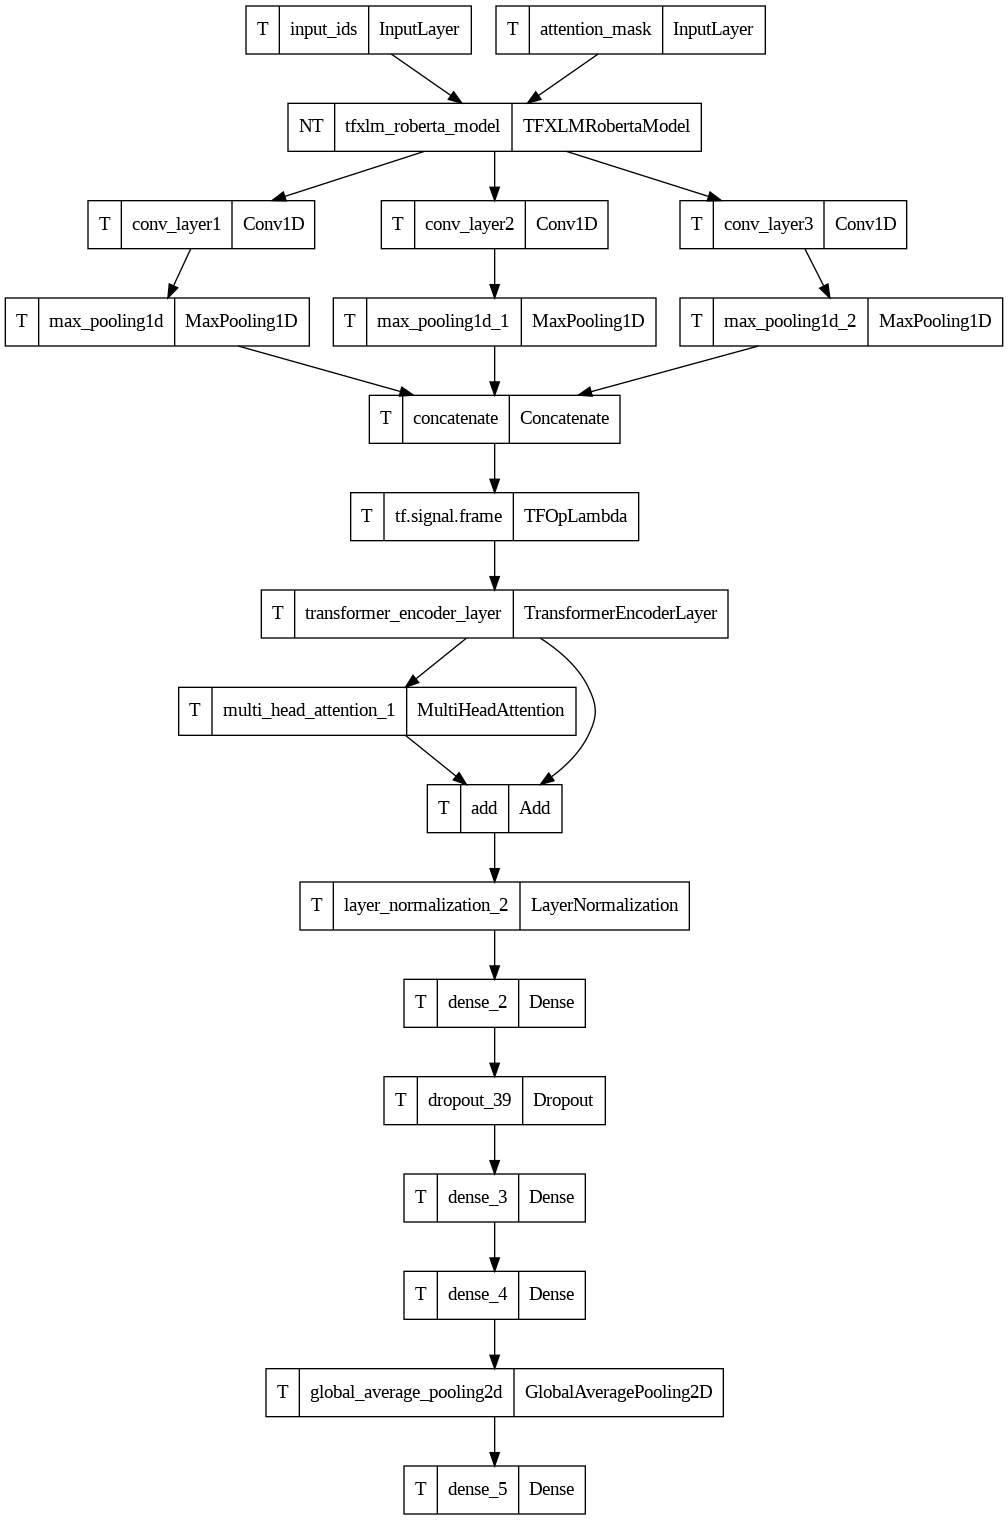

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=True,
)

In [ ]:
def fit(Xtrain, ytrain, max_length=64):

  X_train = tokenizer(
    text=Xtrain.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

  # X_test = tokenizer(
  #   text=Xtest.tolist(),
  #   add_special_tokens=True,
  #   max_length=max_length,
  #   truncation=True,
  #   padding='max_length',
  #   return_tensors='tf',
  #   return_token_type_ids = False,
  #   return_attention_mask = True,
  #   verbose = True)

  model = bert_model()

  best_weights_file = "best" + "_weights.h5"
  mc = ModelCheckpoint(best_weights_file, monitor='val_accuracy', verbose=1, save_best_only=True)
  history = model.fit(
      {'input_ids':X_train['input_ids'],'attention_mask':X_train['attention_mask']} , ytrain,
      validation_split=0.2,
      epochs=30,
      batch_size=4,
      callbacks=[mc],
      verbose=1)
fit(X, y)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_model_1 (TFX  TFBaseModelOutputWithPooli   2780436   ['input_ids[0][0]',           
 LMRobertaModel)             ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, 64, 76                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 54s 36ms/step - loss: 0.5691 - accuracy: 0.7872 - val_loss: 0.4725 - val_accuracy: 0.8230
Epoch 2/30
 999/1000 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.7975
Epoch 2: val_accuracy improved from 0.82300 to 0.82700, saving model to best_weights.h5
1000/1000 [==============================] - 39s 39ms/step - loss: 0.5160 - accuracy: 0.7975 - val_loss: 0.4617 - val_accuracy: 0.8270
Epoch 3/30
 999/1000 [============================>.] - ETA: 0s - loss: 0.4833 - accuracy: 0.8128
Epoch 3: val_accuracy did not improve from 0.82700
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4833 - accuracy: 0.8125 - val_loss: 0.4738 - val_accuracy: 0.8200
Epoch 4/30
1000/1000 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8155
Epoch 4: val_accuracy improved from 0.82700 to 0.83200, saving model to best_weights.h5
1000/1000 [==============================] - 40s 40ms/step - loss: 0.4729 

In [ ]:
from keras.models import load_model
from transformers import BertTokenizer, TFXLMRobertaModel

model = load_model('/content/drive/MyDrive/best_weights.h5', compile=False,
                       custom_objects={"TFXLMRobertaModel": TFXLMRobertaModel})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_model (TFXLM  TFBaseModelOutputWithPooli   2780436   ['input_ids[0][0]',           
 RobertaModel)               ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, 64, 76                                     

In [ ]:
def fit(Xtrain, ytrain, max_length=64):

  X_train = tokenizer(
    text=Xtrain.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
  model = load_model('/content/best_weights.h5', custom_objects={"TFXLMRobertaModel": TFXLMRobertaModel,
                                                                 "TransformerEncoderLayer":TransformerEncoderLayer})
  print('model loaded!')
  model.layers[2].trainable = False

  adam = tf.keras.optimizers.Adam(learning_rate=3e-5)
  model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # X_test = tokenizer(
  #   text=Xtest.tolist(),
  #   add_special_tokens=True,
  #   max_length=max_length,
  #   truncation=True,
  #   padding='max_length',
  #   return_tensors='tf',
  #   return_token_type_ids = False,
  #   return_attention_mask = True,
  #   verbose = True)


  best_weights_file = "best" + "_weights.h5"
  mc = ModelCheckpoint(best_weights_file, monitor='accuracy', verbose=1, save_best_only=True)
  history = model.fit(
      {'input_ids':X_train['input_ids'],'attention_mask':X_train['attention_mask']} , ytrain,
      validation_split=0.2,
      epochs=20,
      batch_size=8,
      callbacks=[mc],
      verbose=1)
fit(X, y)

model loaded!
Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8255
Epoch 1: accuracy improved from -inf to 0.82550, saving model to best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 117s 208ms/step - loss: 0.4397 - accuracy: 0.8255 - val_loss: 0.4977 - val_accuracy: 0.7940
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8372
Epoch 2: accuracy improved from 0.82550 to 0.83725, saving model to best_weights.h5
500/500 [==============================] - 107s 213ms/step - loss: 0.4129 - accuracy: 0.8372 - val_loss: 0.5640 - val_accuracy: 0.7620
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8450
Epoch 3: accuracy improved from 0.83725 to 0.84500, saving model to best_weights.h5
500/500 [==============================] - 106s 211ms/step - loss: 0.4018 - accuracy: 0.8450 - val_loss: 0.4969 - val_accuracy: 0.8170
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8425
Epoch 4: accuracy did not improve from 0.84500
500/500 [==============================] - 95s 190ms/step - loss: 0.3998 - accuracy: 0.8425 

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, TFXLMRobertaModel
import pandas as pd
import numpy as np
MAX_LENGTH = 256
def get_model():
    # tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Robertasentiment/bert-tokenizer')
    print('loading model ...')
    model = load_model('/content/best_weights.h5', compile=False,
                       custom_objects={"TFXLMRobertaModel": TFXLMRobertaModel,
                                       "TransformerEncoderLayer":TransformerEncoderLayer})
    print('model loaded!')

    adam = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return tokenizer, model


def test(Xtest, max_length=64):
    tokenizer, model = get_model()

    X_test = tokenizer(
        text=Xtest.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)

    y_pred = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
    y_pred = np.argmax(y_pred, axis=1)

    return y_pred

    # print(accuracy_score(ytest, y_pred))

    # macro_f1 = f1_score(ytest, y_pred, average='macro')
    # micro_f1 = f1_score(ytest, y_pred, average='micro')
    # weighted_f1 = f1_score(ytest, y_pred, average='weighted')
    # print(f'macro_f1 = {macro_f1}')
    # print(f'micro_f1 = {micro_f1}')
    # print(f'weighted_f1 = {weighted_f1}')

In [ ]:
!gdown 1CvdZ4F4Dh3RtN2_Km_HjpdzFCtkXfaL2
dft = pd.read_csv('/content/4. test_data_sentiment_without_label.csv')

sentences_t = dft['tweet']
X_t = np.asarray(sentences_t)

y_pred = test(X_t)
dft['predicted'] = y_pred

Downloading...
From: https://drive.google.com/uc?id=1CvdZ4F4Dh3RtN2_Km_HjpdzFCtkXfaL2
To: /content/4. test_data_sentiment_without_label.csv
100% 315k/315k [00:00<00:00, 115MB/s]
loading model ...
model loaded!
32/32 [==============================] - 13s 303ms/step


In [ ]:
dft['negative'] = 0
dft['neutral'] = 0
dft['positive'] = 0
for i in dft.index:
  if dft['predicted'][i] == 0:
    dft['negative'][i] = 1
  if dft['predicted'][i] == 1:
    dft['neutral'][i] = 1
  if dft['predicted'][i] == 2:
    dft['positive'][i] = 1
del dft['predicted']

dft

<ipython-input-18-e7bf993d8522>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['positive'][i] = 1
<ipython-input-18-e7bf993d8522>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['neutral'][i] = 1
<ipython-input-18-e7bf993d8522>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['negative'][i] = 1


,local_id,tweet,negative,neutral,positive
0,1565262820316512258,اواسط دهه هفتاد بود که کتاب سمفونی مردگان #عبا...,0,0,1
1,1635176520493981697,رقص تانگو به سبک عربستان و جمهوری اسلامی – حسن...,0,1,0
2,1634294291710500867,توافق ایران و عربستان برای از سرگیری مناسبات د...,0,1,0
3,1651233845981638658,آیت‌الله خوشوقت :\nشياطين رها نمی‌کنند و منتظر...,1,0,0
4,1659172316553641984,یک گزارش نشان می‌دهد ۴۹ درصد از کارمندان مایکر...,0,1,0
...,...,...,...,...,...
995,1635416133615628288,بوی گل رنگ شقایق // رنگ شادی رقص یار // جلوه ز...,0,0,1
996,1505571328828620802,بوی جان می آید اینک از نفس های بهار\nدستهای پر...,0,0,1
997,1634944934750068738,آمریکا ادعای ایران مبنی بر توافق برای تبادل زن...,1,0,0
998,1637839565292535808,اولیور شولز، ۴۱ ساله، اولین سرباز یا سرباز ساب...,1,0,0


In [ ]:
dft.to_csv("predict_sentiment_f2.csv", encoding='utf-8-sig')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
absa = pd.read_excel("/content/fa.xlsx")
absa


In [ ]:
print(absa["label"].value_counts())


-1    3070
 1    1212
 2     386
 0     311
 3      21
Name: label, dtype: int64


In [ ]:
!git clone https://github.com/Arman-Rayan-Sharif/arman-text-emotion.git

Cloning into 'arman-text-emotion'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 52 (delta 10), reused 9 (delta 2), pack-reused 0
Receiving objects: 100% (52/52), 572.39 KiB | 6.98 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
!wget https://www.kaggle.com/datasets/behdadkarimi/persian-tweets-emotional-dataset?resource=download&select=joy.csv

--2023-09-12 13:24:41--  https://www.kaggle.com/datasets/behdadkarimi/persian-tweets-emotional-dataset?resource=download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘persian-tweets-emotional-dataset?resource=download’

persian-tweets-emot     [ <=>                ]  13.75K  --.-KB/s    in 0s      

2023-09-12 13:24:41 (53.0 MB/s) - ‘persian-tweets-emotional-dataset?resource=download’ saved [14085]

